In [1]:
import os
from random import shuffle
import json
from itertools import product

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from src.models.monuseg.models import get_model
from src.data.monuseg.tf_data import get_dataset, tf_random_crop
from src.models.loss import dice_coe_loss, dice_coe_metric
from src.models.monuseg.evaluation import post_processing

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

path_indices = "/home/valentin/python_wkspce/2d_bispectrum_cnn/data/indices/monuseg.json"
split = 0

In [2]:
w_fg = 1.9
w_border = 5.0
w_bg = 0.44


def loss(y_true, y_pred):
    l = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    w = (y_true[..., 0] * w_fg + y_true[..., 1] * w_border +
         y_true[..., 2] * w_bg)
    return tf.reduce_mean(w * l, axis=(1, 2))

In [3]:
with open(path_indices, "r") as f:
    indices_list = json.load(f)

ds_train = get_dataset(id_list=indices_list[split]["train"]).take(1)
ds_train = ds_train.cache().repeat(15)
f1 = lambda image, seg: tf_random_crop(
    image, seg, rotation_angle="right-angle")
f2 = lambda image, seg: (
    tf.image.random_brightness(image, max_delta=0.2),
    seg,
)
ds_train = ds_train.map(f1).map(f2).batch(4)

ds_val = get_dataset(id_list=indices_list[split]["val"])
ds_val = ds_val.cache().batch(1)

ds_val_instance = get_dataset(id_list=indices_list[split]["val"],
                              instance=True)
ds_val_instance = ds_val_instance.cache().batch(1)

ds_test = get_dataset(id_list=indices_list[split]["test"], instance=True)
ds_test = ds_test.cache().batch(1)


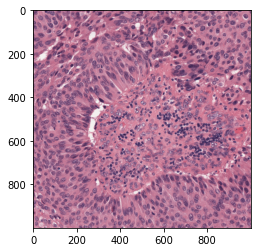

In [4]:
images, segs = next(ds_test.as_numpy_iterator())
plt.imshow(images[0,...])

In [5]:
def rotate_batch(images, angle=90):
    output = np.zeros_like(images)
    for n in range(images.shape[0]):
        output[n, ...] = rotate(images[n, ...], angle=angle, reshape=False)
    return output


In [6]:
model = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=4,
    n_feature_maps=[8, 16, 32],
    radial_profile_type="disks",
)


In [13]:
ds_sample = ds_test.as_numpy_iterator()

In [14]:
x, y = next(ds_sample)

In [23]:
x = x[:, :256, :256, :]
x.shape

(1, 256, 256, 3)

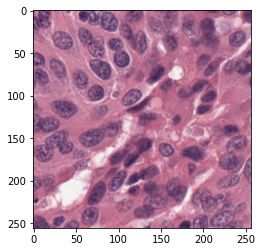

In [24]:
plt.imshow(x[0,...])

In [25]:
y_pred = model(x)

In [27]:
model.load_weights(
    "/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/BispectUnet__rotation_True__nh_4__n_train_-1__psize_60x60__20211212-222233/weights/split_0/final"
)


In [34]:
angle = 90
x_rotated = rotate_batch(x, angle=angle)

TypeError: rotate() missing 1 required positional argument: 'angle'

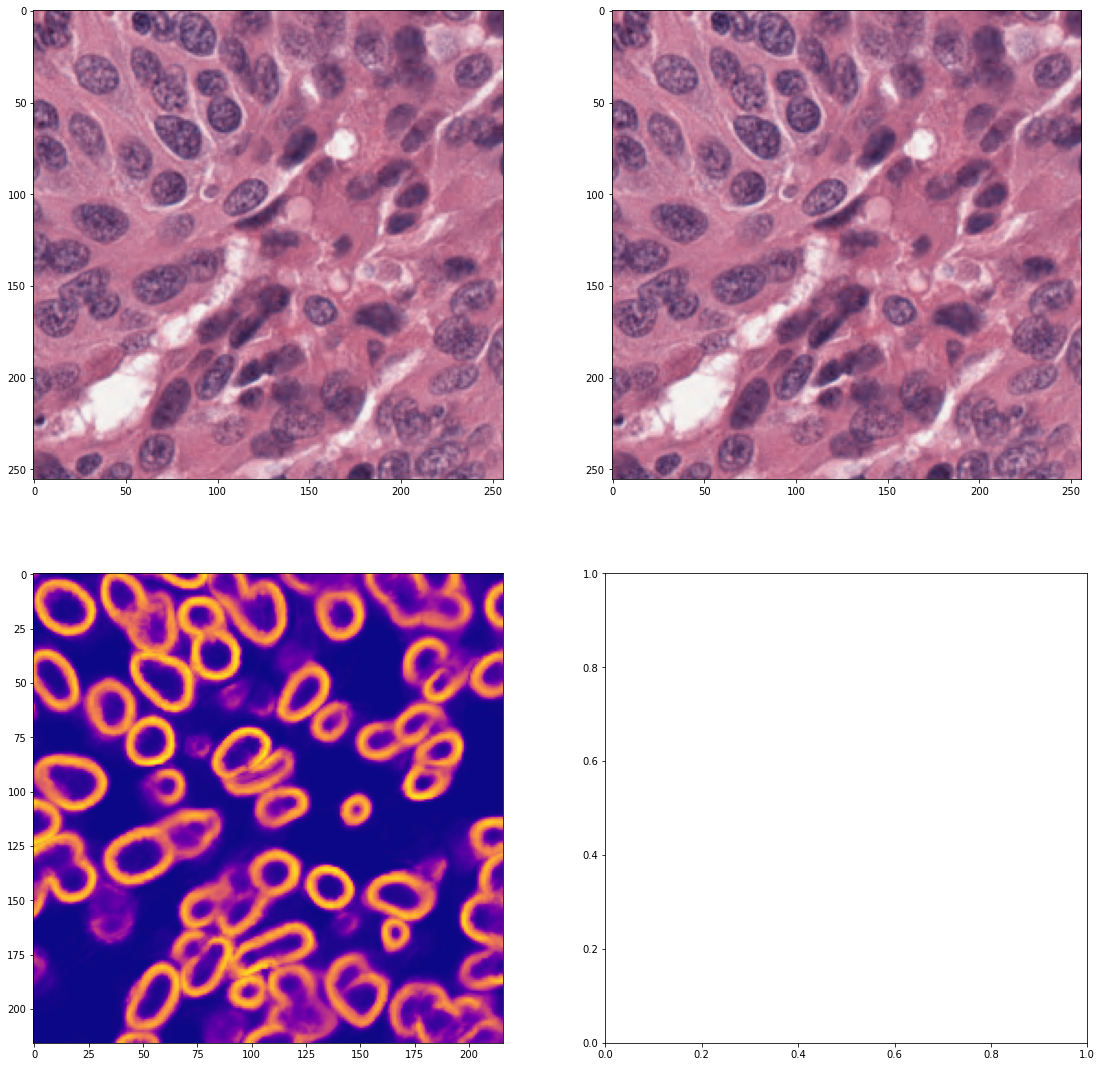

In [35]:
plt.figure(figsize=(19, 19))
plt.subplot(221)
plt.imshow(x[0, ...])
plt.subplot(222)
plt.imshow(rotate_batch(x_rotated[0, ...], -angle))
plt.subplot(223)
plt.imshow((model(x))[0, :, :, 1], cmap="plasma")
plt.subplot(224)
plt.imshow((rotate(model(x_rotated))[0, :, :, 1], -angle), cmap="plasma")


In [ ]:
np.min(model(x))

In [ ]:
y_diff = model(x) - rotate_batch(model(x_rotated), angle=-90)

In [ ]:
plt.imshow(y_diff[0,:,:,1])
plt.colorbar()

In [ ]:
unet = get_model(
    model_name="Unet",
    output_channels=3,
    n_feature_maps=[11, 22, 44],
)


In [ ]:
unet.summary()

In [ ]:
y_diff = unet(x) - rotate_batch(unet(x_rotated), angle=-90)
plt.imshow(y_diff[0, ..., 0])
plt.colorbar()

In [ ]:
unet.load_weights(
    "/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/Unet__rotation_True__nh_0__n_train_-1__psize_60x60__20211130-080306/weights/split_2/final"
)


In [ ]:
y_diff = unet(x) - rotate_batch(unet(x_rotated), angle=-90)
plt.imshow(y_diff[0, ..., 0])
plt.colorbar()

In [ ]:
f = model.down_block_1.get_layer(index=0).conv_ch.filters.numpy()
f.shape

In [ ]:
plt.subplot(211)
plt.imshow(radial_profile[:, :, 0])
plt.subplot(212)
plt.imshow(radial_profile[:, :, 1])


In [ ]:
model.down_block_1.get_layer(index=0).indices

In [ ]:
model_2 = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=5,
    n_feature_maps=[10, 20, 40],
    radial_profile_type="disks",
)


In [ ]:
y_diff = model_2(x) - rotate_batch(model_2(x_rotated), angle=-90)
plt.imshow(y_diff[0, ..., 1])
plt.colorbar()

In [ ]:
indices = model_2.down_block_1.get_layer(index=0).indices

In [ ]:
len(indices)

In [ ]:
indices